In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
#Configurations
LEARNING_RATE = 1e-3
STYLE_WEIGHT = 40
CONTENT_WEIGHT = 2
TOTAL_VARIATION_WEIGHT = 200
EPOCHS = 2
BATCH_SIZE = 8
SAVE_PERIOD = 1000
LOG_PERIOD = 100
SAVED_MODEL_PATH = "/tmp/saved_models"
CONTENT_FILE_PATH = "/tmp/data/train2014"
STYLE_PATH = "/tmp/udnie.jpg"
CONTENT_LAYERS = ['block4_conv2']
STYLE_LAYERS = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [4]:
!mkdir /tmp/data
!mkdir /tmp/data/train2014

In [5]:
!wget http://images.cocodataset.org/zips/train2014.zip -O /tmp/train2014.zip

--2023-07-10 09:55:45--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.222.33, 52.217.121.121, 54.231.138.105, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.222.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘/tmp/train2014.zip’

/tmp/train2014.zip  100%[===================>]  12.58G  45.9MB/s    in 4m 58s  

2023-07-10 10:00:43 (43.3 MB/s) - ‘/tmp/train2014.zip’ saved [13510573713/13510573713]



In [6]:
!unzip -q /tmp/train2014.zip -d /tmp/data

In [7]:
!rm /tmp/train2014.zip

In [8]:
!wget -q https://static.wixstatic.com/media/507339_37d143096d6249f3b7253a4b474a1a3a~mv2.jpg -O /tmp/udnie.jpg
!wget -q https://static.wixstatic.com/media/507339_e9064ed1c95d4e1eb76d31ff13117d9e~mv2.jpg -O /tmp/mosaic.jpg
!wget -q https://static.wixstatic.com/media/507339_f11f19449cd54141a1e95ad4b4419ccf~mv2.jpg -O /tmp/the_scream.jpg
!wget -q https://static.wixstatic.com/media/507339_62306b21cef045d599ac272aa410ca3a~mv2.jpg -O /tmp/rain_princess.jpg
!wget -q https://static.wixstatic.com/media/507339_b3b8b65faa854e83b6924344594b2807~mv2.jpg -O /tmp/wave.jpg
!wget -q https://static.wixstatic.com/media/507339_0d4a0400a92c4db28353d9daab20bad0~mv2.jpg -O /tmp/chicago.jpg

In [9]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage import transform
import numpy as np

def get_image(img_path, img_size=False):
  img = load_img(img_path)
  img = img_to_array(img, dtype=np.float32)
  if img_size != False:
    img = resize_img(img, img_size)
  return img

def resize_img(img, size):
  if len(size) == 2:
    size += (3,)
  return transform.resize(img, size, preserve_range=True)

In [10]:
def normalize(img):
    return img / 255.

In [11]:
def clip_0_255(img):
    return tf.clip_by_value(img, 0., 255.)

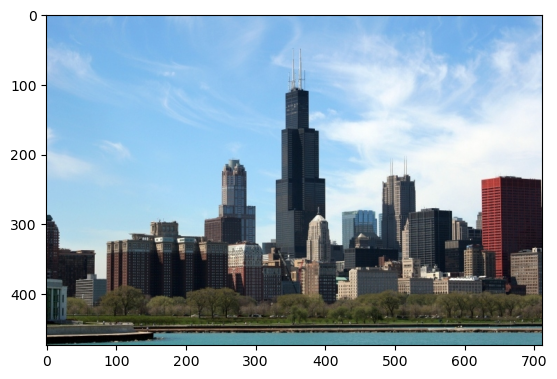

In [12]:
plt.imshow(get_image("/tmp/chicago.jpg") / 255)

# **Image Transform Net**

In [13]:
class ConvBlock(tf.keras.layers.Layer):
    '''
    conv2d -> batchnorm -> relu
    '''
    def __init__(self, filters, kernel_size, strides = (1, 1), padding = "valid", upsample = False):
        super(ConvBlock, self).__init__()
        if(upsample):
            self.conv = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides = strides, padding = padding, use_bias = False)
        else:
            self.conv = tf.keras.layers.Conv2D(filters, kernel_size, strides = strides, padding = padding, use_bias = False)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
    
    def call(self, input_tensor):
        x = self.conv(input_tensor)
        x = self.bn(x)
        x = self.relu(x)

        return x

In [14]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters = 128):
        super(ResidualBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters, (3, 3), strides = (1, 1), padding = "same", use_bias = False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(filters, (3, 3), strides = (1, 1), padding = "same", use_bias = False)
        self.bn2 = tf.keras.layers.BatchNormalization()
    
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x += input_tensor

        return x

In [15]:
class OutputBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides = (1, 1), padding = "valid"):
        super(OutputBlock, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters, kernel_size, strides = strides, padding = padding, use_bias = False)
        self.bn = tf.keras.layers.BatchNormalization()
        self.tanh = tf.keras.layers.Activation('tanh')
    
    def call(self, input_tensor):
        x = self.conv(input_tensor)
        x = self.bn(x)
        x = (self.tanh(x) + 1) * 255 / 2

        return x

In [16]:
class ImageTransformNet(tf.keras.Model):
    def __init__(self):
        super(ImageTransformNet, self).__init__()
        self.conv_block1 = ConvBlock(32, (9, 9), strides = (1, 1), padding = "same")
        self.conv_block2 = ConvBlock(64, (3, 3), strides = (2, 2), padding = "same")
        self.conv_block3 = ConvBlock(128, (3, 3), strides = (2, 2), padding = "same")
        self.res_block1 = ResidualBlock(128)
        self.res_block2 = ResidualBlock(128)
        self.res_block3 = ResidualBlock(128)
        self.res_block4 = ResidualBlock(128)
        self.res_block5 = ResidualBlock(128)
        self.conv_block4 = ConvBlock(64, (3, 3), strides = (2, 2), padding = "same", upsample = True)
        self.conv_block5 = ConvBlock(32, (3, 3), strides = (2, 2), padding = "same", upsample = True)
        self.out_block = OutputBlock(3, (9, 9), strides = (1, 1), padding = "same") 

    def call(self, input_tensor):
        x = self.conv_block1(input_tensor)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        x = self.res_block5(x)

        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.out_block(x)

        return x

In [17]:
image_transform_net_ = ImageTransformNet()
inputs = tf.keras.Input(shape=(None, None, 3))
outputs =image_transform_net_(inputs)
image_transform_net = tf.keras.Model(inputs=inputs, outputs=outputs)

# **Loss Network**

In [18]:
vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80134624/80134624 [==============================] - 0s 0us/step


In [19]:
for layer in vgg19.layers:
  print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [20]:
num_content_layers = len(CONTENT_LAYERS)
num_style_layers = len(STYLE_LAYERS)

In [21]:
def vgg19_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg19.trainable = False
  
  outputs = [vgg19.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg19.input], outputs)
  return model

In [22]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg19 = vgg19_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg19.trainable = False

  def call(self, inputs):
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg19(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [23]:
extractor = StyleContentModel(STYLE_LAYERS, CONTENT_LAYERS)

In [24]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2]*input_shape[3], tf.float32)
  return result/(num_locations)

In [25]:
def content_loss(content_outputs, content_targets):
    loss = 0
    for name in CONTENT_LAYERS:
        loss += 2 * tf.nn.l2_loss(content_outputs[name] - content_targets[name]) / num_content_layers /  tf.cast(tf.reduce_prod(content_outputs[name].shape), tf.float32)
    return loss

In [26]:
def style_loss(style_outputs, style_targets):
    loss = 0
    for name in STYLE_LAYERS:
        loss += 2 * tf.nn.l2_loss(style_outputs[name] - style_targets[name]) / num_style_layers / tf.cast(tf.reduce_prod(style_outputs[name].shape), tf.float32)
    return loss 

In [27]:
def total_variation_loss(img):
    return tf.reduce_sum(tf.image.total_variation(img)) / img.shape[1] / img.shape[2]

# **Training**

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [29]:
@tf.function()
def train_step(content_images, style_image):
  with tf.GradientTape() as tape:
    content_images = normalize(content_images)
    y_hat = image_transform_net(content_images)
    y_hat = clip_0_255(y_hat)
    outputs = extractor(y_hat)

    content_targets = extractor(content_images)["content"]

    c_loss = CONTENT_WEIGHT * content_loss(outputs["content"], content_targets)
    s_loss = STYLE_WEIGHT * style_loss(outputs["style"], style_targets)
    tv_loss = TOTAL_VARIATION_WEIGHT * total_variation_loss(y_hat)

    total_loss = c_loss + s_loss + tv_loss
  grad = tape.gradient(total_loss, image_transform_net.trainable_variables)
  opt.apply_gradients(zip(grad, image_transform_net.trainable_variables))
  return total_loss, s_loss, c_loss, tv_loss

In [30]:
content_paths = glob(os.path.join(CONTENT_FILE_PATH, "*.jpg"))
num_images = len(content_paths) - (len(content_paths) % BATCH_SIZE)

In [ ]:
losses = []
iter = 0
style_image = get_image(STYLE_PATH)
style_image = style_image[tf.newaxis,:]
style_targets = extractor(style_image)["style"]
for epoch in range(EPOCHS):
    for batch in [content_paths[i:i+BATCH_SIZE] for i in range(0, num_images, BATCH_SIZE)]:
        content_images = [get_image(img_path, (256, 256, 3)) for img_path in batch]
       
        content_images = tf.convert_to_tensor(content_images)
        total_loss, s_loss, c_loss, tv_loss = train_step(content_images, style_image)
        losses.append(total_loss)
        if iter % LOG_PERIOD == 0:
            print(f"ITER {iter} Loss: {total_loss.numpy()}, Style_loss: {s_loss.numpy()}, Content_loss: {c_loss.numpy()}, Total_variation_loss: {tv_loss.numpy()}")
        iter += 1
        if(iter % SAVE_PERIOD == 0):
            tf.keras.models.save_model(model=image_transform_net, filepath=SAVED_MODEL_PATH)

In [ ]:
!zip -r saved_models.zip /tmp/saved_models